In [67]:
import librosa
import librosa.feature
import librosa.display

import matplotlib.pyplot as plt

import numpy as np
from scipy import signal
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
import sklearn.metrics
import sklearn

from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage

import torch
import torchaudio

import seaborn as sns

import pandas as pd
import os
import re

from FSDDComparisonHelp import FSDD, getMFCC, getTwoMFCCs, showMFCC, compareFeatures

# plt.style.use("classic")
# plt.style.use("bmh")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.grid'] = True

In [68]:
def getTrainSet(speakerFilesList : list):
	trainList = []
	for file in speakerFilesList:
		y, sr = librosa.load(file)
		# S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=80, fmax=8000)
		S = librosa.feature.mfcc(y=y, sr=sr, dct_type=1)
		trainList.append(S)
	# trim
	minLen = min(el.shape[1] for el in trainList)
	trainList = [el[:, :minLen] for el in trainList]
	# stack
	train = np.stack(trainList)
	# reshape to 2d
	nSamples, nx, ny = train.shape
	twoDimTrain = train.reshape((nSamples, nx*ny))
	print(f'nx = {nx}, ny = {ny}')
	return twoDimTrain, nx, ny


def getTestSet(speakerFilesList : list, maxLen : int):
	trainList = []
	for file in speakerFilesList:
		y, sr = librosa.load(file)
		# S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=80, fmax=8000)
		S = librosa.feature.mfcc(y=y, sr=sr, dct_type=1)
		trainList.append(S)
	# trim
	minLen = min(el.shape[1] for el in trainList)
	trainList = [el[:, :min(maxLen, minLen)] for el in trainList]
	# shapes = {arr.shape for arr in trainList}
	# print(shapes)
	# stack
	train = np.stack(trainList)
	# reshape to 2d
	nSamples, nx, ny = train.shape
	twoDimTrain = train.reshape((nSamples, nx*ny))
	print(f'nx = {nx}, ny = {ny}')
	return twoDimTrain


def getFeatureList(speakerFilesList : list):
	featureList = []
	for file in speakerFilesList:
		y, sr = librosa.load(file)
		# S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=80, fmax=8000)
		S = librosa.feature.mfcc(y=y, sr=sr, dct_type=3)
		featureList.append(S)
	return featureList

def trimFeatures(collection : list):
	newCollection = []
	minLen = min(min([feature.shape[1] for feature in featureList]) for featureList in collection)
	for featureList in collection:
		newFeatureList = [feature[:, :minLen] for feature in featureList]
		newCollection.append(newFeatureList)
	return newCollection

def getLinearFeatureList(featureList : list):
	res = np.stack(featureList)
	# reshape to 2d
	nSamples, nx, ny = res.shape
	twoDimRes = res.reshape((nSamples, nx*ny))
	return twoDimRes, nx, ny

# def trim(collection):
# 	minLen = min(el.shape[1] for el in collection)
# 	collection = [el[:, :minLen] for el in collection]

In [95]:
spkA = 3
spkB = 5
fsdd = FSDD('../Datasets/FSDD/recordings')
filesA, filesB = fsdd.getFilesForDigit(0, spkA=spkA, spkB=spkB)
print(fsdd.speakers[spkA])
print(fsdd.speakers[spkB])
# nicolas -- bad

theo
lucas


In [6]:
# fA0, sr = librosa.load(filesA[0])
# S = librosa.feature.mfcc(y=fA0, sr=sr, n_mels=128, n_fft=512, dct_type=2)
# librosa.display.specshow(S, sr=sr, x_axis='time', cmap = 'bwr')
# plt.show()

In [96]:
trainA, nx, ny = getTrainSet(filesA)
trainB, nx, ny = getTrainSet(filesB)

gmA = GaussianMixture(n_components=1, random_state=0).fit(trainA)
gmB = GaussianMixture(n_components=1, random_state=0).fit(trainB)

nx = 20, ny = 13
nx = 20, ny = 21


In [8]:
# если заюзать спектрограмму с вытащить mean:
# librosa.display.specshow(gmA.means_.reshape((80, 13)), sr=8000, x_axis='time', cmap = 'bwr')
# plt.show()

In [9]:
# sns.distplot(trainA[:, 0], hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3})
# sns.distplot(trainB[:, 0], hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3})
# plt.show()

In [ ]:
fps = 15
duration = min( int((trainA.shape[1] - 2) / fps), int((trainB.shape[1] - 2) / fps))
print(f'Duration: {duration}')

# figsize - 1 == 72px -> 20 - 1440p | 15 - 1080p
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot()
plt.rcParams['axes.grid'] = False

idx = 0
def make_frame(t):
	global idx
	ax.clear()
	sns.distplot(trainA[:, idx], hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3}, ax=ax)
	sns.distplot(trainB[:, idx], hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3}, ax=ax)	
	npimg = mplfig_to_npimage(fig)
	idx += 1
	return npimg

animation = VideoClip(make_frame, duration=duration)
animation.write_videofile(f'final{3}.mp4', fps=fps, codec='mpeg4', audio=False, bitrate='6M', threads = 12, preset='ultrafast')
plt.rcParams['axes.grid'] = True

In [71]:
trainA.shape

(50, 300)

In [72]:
gmA.means_.shape

(1, 300)

In [73]:
gmA.covariances_.shape

(1, 300, 300)

In [77]:
rlistA = []
for el in trainA:
    x = el
    means = np.squeeze(gmA.means_)
    cov = np.squeeze(gmA.covariances_)

    r = (x - means).T @ np.linalg.inv(cov) @ (x - means)
    rlistA.append(r)
print(rlistA)

[48.99999782047337, 48.99999943828976, 49.00000008738696, 48.99999917182773, 49.00000059788302, 48.99999882538329, 48.999998361526075, 48.99999900081135, 49.00000157418045, 48.999997839939184, 48.99999852541305, 48.999996241620636, 48.99999960692771, 48.999994421277194, 49.00000214848941, 48.99999951672527, 49.0000033942305, 49.00000037740206, 48.99999899621736, 49.00000035120634, 49.00000002763097, 48.99999769606855, 48.99999921954636, 48.999999270798554, 49.00000054917095, 48.99999983293693, 49.000000477495604, 48.99999904322217, 48.99999816538012, 49.000000416431945, 49.00000009103097, 48.999999492458954, 48.999999195280246, 48.99999874072769, 48.99999851283165, 48.999999305669434, 48.999998437864775, 49.00000017636876, 48.9999986925589, 48.99999882439156, 48.99999946483164, 48.99999968964063, 48.99999885609024, 49.00000216370183, 48.999995619469374, 48.9999996950311, 48.99999962966246, 49.00000148577086, 49.00000017823186, 48.99999552012459]


In [79]:
rlistB = []
for el in trainB:
    x = el
    means = np.squeeze(gmB.means_)
    cov = np.squeeze(gmB.covariances_)

    r = (x - means).T @ np.linalg.inv(cov) @ (x - means)
    rlistB.append(r)
print(rlistB)

[48.99999112083552, 48.99998775645151, 48.99998547818282, 48.99999636657663, 48.9999994127418, 48.99999340559522, 48.99999664340785, 48.99999393514898, 48.99999068707876, 48.99999386324066, 48.99999239272547, 49.00000191047043, 48.99998581142637, 48.99999887501631, 49.00000281158695, 48.999988676231744, 49.00002446398804, 48.99999912790719, 49.00000204880901, 48.999998957967776, 49.00000659845412, 48.999992959709125, 49.00000892526702, 49.00000261780019, 49.00000036620443, 49.000009635192406, 48.99999968955239, 49.000013408259385, 49.000025790150595, 48.99999568593511, 48.99999513768976, 49.00000296366326, 48.99999622423013, 48.99999513740771, 49.00000529305669, 48.99998988151392, 48.999980676072255, 48.99999460480169, 48.99999431296431, 49.00000465603132, 48.999995661205666, 48.999996386511135, 49.00000178207725, 49.00000454818184, 48.99999961660437, 49.000022588789925, 49.00000009785784, 49.00000240528911, 49.000010752614045, 48.999998086225894]


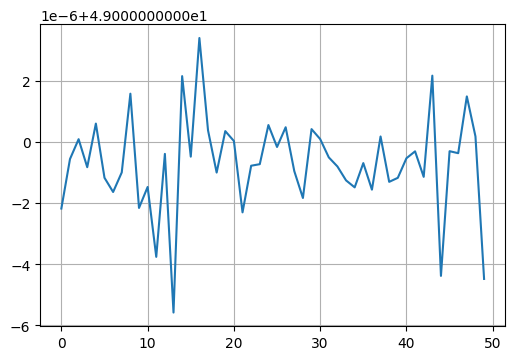

In [80]:
plt.plot(range(len(rlistA)), rlistA)
plt.show()

In [17]:
trainB.shape[1]

420

In [ ]:
fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot()
sns.heatmap(np.squeeze(gmA.covariances_, axis=0), square=True, ax=ax)
plt.show()

In [61]:
fsdd = FSDD('../Datasets/FSDD/recordings')
filesA, filesB = fsdd.getFilesForDigit(0, spkA=0, spkB=3)

train2, nx, ny = getTrainSet([*filesA, *filesB])

gm2 = GaussianMixture(n_components=2, random_state=0).fit(train2)

for i in range(len(filesA)):
	for j in range(len(filesB)):
		test2 = [train2[i], train2[-j-1]]
		a, b = gm2.predict(test2)
		if a == b:
			print(i, j)

nx = 20, ny = 13
0 19
0 20
1 19
1 20
2 19
2 20
3 19
3 20
4 19
4 20
5 19
5 20
6 19
6 20
7 19
7 20
8 19
8 20
9 19
9 20
10 19
10 20
11 19
11 20
12 19
12 20
13 19
13 20
14 19
14 20
15 19
15 20
16 19
16 20
17 19
17 20
18 19
18 20
19 19
19 20
20 19
20 20
21 19
21 20
22 19
22 20
23 19
23 20
24 19
24 20
25 19
25 20
26 19
26 20
27 19
27 20
28 19
28 20
29 19
29 20
30 19
30 20
31 19
31 20
32 19
32 20
33 19
33 20
34 19
34 20
35 19
35 20
36 19
36 20
37 19
37 20
38 19
38 20
39 19
39 20
40 19
40 20
41 19
41 20
42 19
42 20
43 19
43 20
44 19
44 20
45 19
45 20
46 19
46 20
47 19
47 20
48 19
48 20
49 19
49 20


In [63]:
gm2.covariances_.shape

(2, 260, 260)

In [ ]:
# fig = plt.figure(figsize=(30, 30))
# ax = fig.add_subplot()
# sns.heatmap(gm2.covariances_[0], square=True, ax=ax)
# plt.show()

In [97]:
fsdd = FSDD('../Datasets/FSDD/recordings')
print(fsdd.speakers)
# spkA = 1
# spkB = 3
filesA, filesB = fsdd.getFilesForDigit(0, spkA=spkA, spkB=spkB)
print(fsdd.speakers[spkA])
print(fsdd.speakers[spkB])

mfccsA = getFeatureList(filesA)
mfccsB = getFeatureList(filesB)
mfccsA, mfccsB = trimFeatures([mfccsA, mfccsB])
# shapesA = {a.shape for a in mfccsA}
# shapesB = {b.shape for b in mfccsB}
# print(shapesA)
# print(shapesB)

['jackson', 'george', 'yweweler', 'theo', 'nicolas', 'lucas']
theo
lucas


In [98]:
# train test split
testsize = 25

train3, nx, ny = getLinearFeatureList([*mfccsA[:-testsize], *mfccsB[:-testsize]])
test3, nx, ny = getLinearFeatureList([*mfccsA[-testsize:], *mfccsB[-testsize:]])

gm3 = GaussianMixture(n_components=2, random_state=0).fit(train3)

Y = gm3.predict(test3)
print(Y)

[1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [99]:
# train test split
testsize = 25

train4A, nx, ny = getLinearFeatureList(mfccsA[:-testsize])
train4B, nx, ny = getLinearFeatureList(mfccsB[:-testsize])

test4A, nx, ny = getLinearFeatureList(mfccsA[-testsize:])
test4B, nx, ny = getLinearFeatureList(mfccsB[-testsize:])
print(nx, ny)

gm4A = GaussianMixture(n_components=1, random_state=0).fit(train4A)
gm4B = GaussianMixture(n_components=1, random_state=0).fit(train4B)


20 13


In [101]:
rlistA = []
for el in test4A:
    x = el
    means = np.squeeze(gm4A.means_)
    cov = np.squeeze(gm4A.covariances_)

    r = (x - means).T @ np.linalg.inv(cov) @ (x - means)
    rlistA.append(r)
print(rlistA)
print(max(rlistA))

[5181459474.774338, 7279093984.080101, 8525880470.674967, 11875845924.36967, 46246772652.73896, 52575838457.94266, 5515756830.801156, 46791939340.200584, 11591386796.137896, 7103460408.926846, 19908997315.663116, 5878108007.277162, 21585309954.436565, 6652950094.445551, 9731726209.53465, 8084780483.288502, 6480303543.180168, 7569555643.444374, 7773383536.139617, 6281494176.93411, 4181744584.46973, 4127077080.451992, 8307342544.934972, 5136594924.186508, 11964443953.528088]
52575838457.94266


In [102]:
rlistB = []
for el in train4B:
    x = el
    means = np.squeeze(gm4A.means_)
    cov = np.squeeze(gm4A.covariances_)

    r = (x - means).T @ np.linalg.inv(cov) @ (x - means)
    rlistB.append(r)
print(rlistB)
print(min(rlistB))

[175305162392.47067, 142646984669.0028, 95242065723.45854, 144559031878.00427, 93007132987.03311, 171994961588.51358, 113810317870.01869, 109183447649.18468, 155928722927.59265, 120953587178.14449, 114340999758.24475, 164874417723.60126, 108157469195.4814, 94464287999.63525, 101647651108.08784, 183762515966.26953, 143098818755.1935, 126619427297.32848, 132533763295.26472, 148245634859.93484, 133727689315.70132, 104236766921.86281, 124695021179.3037, 139918977476.53128, 124569664272.86519]
93007132987.03311


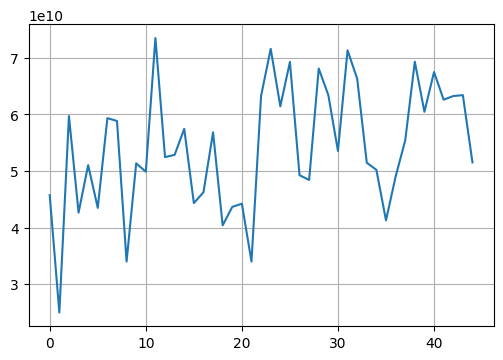

In [24]:
plt.plot(range(len(rlist)), rlist)
plt.show()

In [38]:
sample4a = gm4A.sample(1)[0].reshape((nx, ny))
sample4b = gm4B.sample(1)[0].reshape((nx, ny))

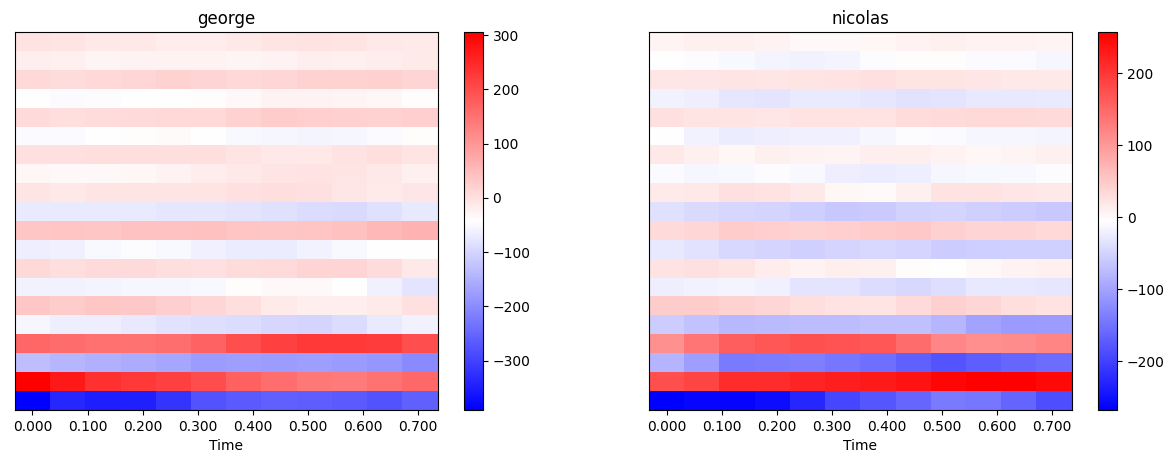

In [39]:
fig, ax = compareFeatures(sample4a, 8000, sample4b, 8000, fsdd.speakers[spkA], fsdd.speakers[spkB])
plt.show()

In [40]:
maxDistSameA = max([np.mean((gm4A.means_ - ta)**2) for ta in test4A])
maxDistSameB = max([np.mean((gm4B.means_ - tb)**2) for tb in test4B])
print(f'Maximum distanse to center of valid:')
print(maxDistSameA)
print(maxDistSameB)
minDistDifA = min([np.mean((gm4A.means_ - tb)**2) for tb in test4B])
minDistDifB = min([np.mean((gm4B.means_ - ta)**2) for ta in test4A])
print(f'Minimum distanse to center of another:')
print(minDistDifA)
print(minDistDifB)

Maximum distanse to center of valid:
111.51540561452933
92.82042286008391
Minimum distanse to center of another:
482.17686680784635
576.9207011601779


In [41]:
cosDist = sklearn.metrics.pairwise.cosine_distances
maxDistSameA = max([cosDist(gm4A.means_.reshape(1, -1), ta.reshape(1, -1)) for ta in test4A])
maxDistSameB = max([cosDist(gm4B.means_.reshape(1, -1), tb.reshape(1, -1)) for tb in test4B])
print(f'Maximum cos dist to center of valid:')
print(maxDistSameA)
print(maxDistSameB)
minDistDifA = min([cosDist(gm4A.means_.reshape(1, -1), tb.reshape(1, -1)) for tb in test4B])
minDistDifB = min([cosDist(gm4B.means_.reshape(1, -1), ta.reshape(1, -1)) for ta in test4A])
print(f'Minimum cos dist to center of another:')
print(minDistDifA)
print(minDistDifB)

Maximum cos dist to center of valid:
[[0.00662717]]
[[0.0042129]]
Minimum cos dist to center of another:
[[0.02492578]]
[[0.03327519]]


In [42]:
# dist = sklearn.metrics.pairwise.manhattan_distances
dist = sklearn.metrics.pairwise.euclidean_distances
maxDistSameA = max([dist(gm4A.means_.reshape(1, -1), ta.reshape(1, -1)) for ta in test4A])
maxDistSameB = max([dist(gm4B.means_.reshape(1, -1), tb.reshape(1, -1)) for tb in test4B])
print(f'Maximum dist to center of valid:')
print(maxDistSameA)
print(maxDistSameB)
minDistDifA = min([dist(gm4A.means_.reshape(1, -1), tb.reshape(1, -1)) for tb in test4B])
minDistDifB = min([dist(gm4B.means_.reshape(1, -1), ta.reshape(1, -1)) for ta in test4A])
print(f'Minimum dist to center of another:')
print(minDistDifA)
print(minDistDifB)

Maximum dist to center of valid:
[[163.59614099]]
[[149.25448565]]
Minimum dist to center of another:
[[340.18002298]]
[[372.10343761]]


In [56]:
cosDist = sklearn.metrics.pairwise.cosine_distances
maxDistSameA = [cosDist(gm4A.means_.reshape(1, -1), ta.reshape(1, -1)).reshape(1)[0] for ta in test4A]
maxDistSameB = [cosDist(gm4B.means_.reshape(1, -1), tb.reshape(1, -1)).reshape(1)[0] for tb in test4B]
print(f'Maximum cos dist to center of valid:')
print(maxDistSameA)
print(maxDistSameB)
minDistDifA = [cosDist(gm4A.means_.reshape(1, -1), tb.reshape(1, -1)).reshape(1)[0] for tb in test4B]
minDistDifB = [cosDist(gm4B.means_.reshape(1, -1), ta.reshape(1, -1)).reshape(1)[0] for ta in test4A]
print(f'Minimum cos dist to center of another:')
print(minDistDifA)
print(minDistDifB)

Maximum cos dist to center of valid:
[0.0016448838384519604, 0.0010362174344308306, 0.0016009652352636516, 0.0023122358419336297, 0.004212900729343327]
[0.004255939838346934, 0.00662717304942928, 0.0037407003183806964, 0.0063756092709850165, 0.005315440915569236]
Minimum cos dist to center of another:
[0.03533937016052424, 0.03619387783986794, 0.033275186655305045, 0.03923102083968444, 0.03460776254390974]
[0.028893752586499732, 0.027420037550162313, 0.027270047049023916, 0.02691663764806551, 0.024925782437525412]


In [57]:
gm4A.lower_bound_

1007.9309487252091

In [58]:
gm4A.score_samples(test4A)

array([-9.77489597e+08, -6.22413467e+08, -9.77647703e+08, -1.36463387e+09,
       -1.06029442e+09])

In [59]:
gm4A.score_samples(test4B)

array([-3.34768731e+10, -3.56301715e+10, -3.34658385e+10, -3.43297538e+10,
       -3.34956103e+10])